# Evaluation Code for KSQL and ML
Before evaluating, please run KSQL infrastructure with `test.pcap` generated from `../datasets/preparation2.py`, then run `../rule-detection/evaluation/consumer/script.py` to consume the results from Kafka, and lastly run `../rule-detection/evaluation/ksql_evaluation_dos.py` and `../rule-detection/evaluation/ksql_evaluation_ps.py` to find list of packets in the pcap (in the form of index) that is malicious/detected.

**Metrics**
- Accuracy, Precision, Recall, F1-Score
- Inference Time for ML

In [1]:
import os
os.environ['OMP_NUM_THREADS'] = "1"

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import joblib
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix,precision_recall_fscore_support, accuracy_score

In [3]:
DOS_MODEL_LOCATION = "../ai-detection/notebooks/models_dos/postfs"
PS_MODEL_LOCATION = "../ai-detection/notebooks/models_ps/postfs"

## Post-Processing for KSQL Predictions

In [4]:
# Get PCAP Indexes of all flows
# For example, if 125th, 126th, and 127th is part of k-th flow (in whole dataset train & test), then flow_packets[k] = [125, 126, 127]
flow_packets = []
with open("../datasets/output-old/pcap_indexes_run_index.txt") as file:
    for line in file:
        indexes = line.strip().split(",")
        if len(indexes[-1]) == 0:
            indexes = indexes[:-1]
        indexes = [int(x) for x in indexes]
        flow_packets.append(indexes)

In [5]:
# Creating mapping to convert whole dataset PCAP indexes to test dataset PCAP indexes
full_to_test_mapping = {}
with open("../datasets/output-old/test_pcap_index_mapping.txt") as file:
    for line in file:
        before, after = line.strip().split(",")
        before = int(before)
        after = int(after)
        assert before not in full_to_test_mapping
        full_to_test_mapping[before] = after

In [6]:
# Convert using mapping
test_flow_packets = []
for cur_packets in flow_packets:
    new_packets = []
    is_in_test = True

    debug_partial = False
    for idx in cur_packets:
        if idx not in full_to_test_mapping:
            is_in_test = False
            assert not debug_partial # if assertion error, there may be problem in your dataset preparation
            break
        debug_partial = True
        new_packets.append(full_to_test_mapping[idx])
    if is_in_test:
        test_flow_packets.append(new_packets)
    else:
        test_flow_packets.append(None)

In [7]:
test_flow_packets_set = [set(i) if i is not None else None for i in test_flow_packets]

In [8]:
np_test_flow_packets_set = pd.Series(np.array(test_flow_packets_set))
flow_packets_set_test_only = np_test_flow_packets_set[~np_test_flow_packets_set.isna()]

In [9]:
with open("../rule-detection/evaluation/detected_ksql_2_slowloris.txt") as file:
    detected_dos_idxs = [int(x.strip()) for x in file.readlines()]
detected_dos_idx_set = set(detected_dos_idxs)

with open("../rule-detection/evaluation/detected_ksql_2_portscan.txt") as file:
    detected_portscan_idxs = [int(x.strip()) for x in file.readlines()]
detected_portscan_idx_set = set(detected_portscan_idxs)

In [10]:
is_detected_dos = np.array([len(detected_dos_idx_set.intersection(flow_packet_set)) > 0 for flow_packet_set in flow_packets_set_test_only.values])
is_detected_dos = pd.Series(is_detected_dos)

is_detected_portscan = np.array([len(detected_portscan_idx_set.intersection(flow_packet_set)) > 0 for flow_packet_set in flow_packets_set_test_only.values])
is_detected_portscan = pd.Series(is_detected_portscan)

In [11]:
is_detected_dos.index = flow_packets_set_test_only.index
is_detected_portscan.index = flow_packets_set_test_only.index

In [12]:
# Load Test Dataset
flink_test = pd.read_csv('../datasets/output/test_final_2.csv', parse_dates=['Timestamp'], index_col=0)

In [13]:
assert set(flink_test['Old Index'].values).issubset(set(is_detected_dos.index))
assert set(flink_test['Old Index'].values).issubset(set(is_detected_portscan.index))

In [14]:
is_detected_dos_df = pd.DataFrame(is_detected_dos, columns=['Binary Prediction']).reset_index().rename(columns={'index': 'Old Index'})
is_detected_dos_df['Binary Prediction'] = np.where(is_detected_dos_df['Binary Prediction'], 'Slowloris', 'Not Slowloris')

is_detected_ps_df = pd.DataFrame(is_detected_portscan, columns=['Binary Prediction']).reset_index().rename(columns={'index': 'Old Index'})
is_detected_ps_df['Binary Prediction'] = np.where(is_detected_ps_df['Binary Prediction'], 'Portscan', 'Not Portscan')

In [15]:
flink_test_binary_dos = flink_test.merge(is_detected_dos_df, on=['Old Index'], how='left', indicator=True)
flink_test_binary_ps = flink_test.merge(is_detected_ps_df, on=['Old Index'], how='left', indicator=True)

In [16]:
flink_test_binary_dos["_merge"].value_counts()

_merge
both          153696
left_only          0
right_only         0
Name: count, dtype: int64

In [17]:
flink_test_binary_ps["_merge"].value_counts()

_merge
both          153696
left_only          0
right_only         0
Name: count, dtype: int64

In [18]:
flink_test_binary_dos['Binary Label'] = np.where(flink_test_binary_dos['Label'] == 'Slowloris', 'Slowloris', 'Not Slowloris')
flink_test_binary_ps['Binary Label'] = np.where(flink_test_binary_ps['Label'] == 'Portscan', 'Portscan', 'Not Portscan')

In [19]:
y_true_dos = flink_test_binary_dos['Binary Label']
y_pred_ksql_dos = flink_test_binary_dos['Binary Prediction']

y_true_ps = flink_test_binary_ps['Binary Label']
y_pred_ksql_ps = flink_test_binary_ps['Binary Prediction']

## Accuracy, Precision, Recall, F1-Score

### DoS

In [21]:
dt = joblib.load(f"{DOS_MODEL_LOCATION}/dt_tuned.pkl")
rf = joblib.load(f"{DOS_MODEL_LOCATION}/rf_tuned_single.pkl")
et = joblib.load(f"{DOS_MODEL_LOCATION}/et_tuned_single.pkl")
xg = joblib.load(f"{DOS_MODEL_LOCATION}/xg_tuned_single.pkl")
lgbm = joblib.load(f"{DOS_MODEL_LOCATION}/lgbm_tuned_single.pkl")
cat = joblib.load(f"{DOS_MODEL_LOCATION}/cat_tuned_single.pkl")
ocse = joblib.load(f"{DOS_MODEL_LOCATION}/ocse_tuned_single.pkl")

fs = ['Bwd IAT Mean', 'Bwd IAT Max', 'Flow Duration', 'Fwd IAT Max', 'Idle Max', 'Flow IAT Max', 'Fwd Seg Size Min', 'Fwd IAT Total', 'Flow IAT Std', 'Idle Mean', 'Flow IAT Mean', 'Bwd IAT Total', 'Bwd IAT Min', 'Protocol', 'Fwd Bulk Rate Avg', 'Bwd Packet Length Max', 'Fwd Packets/s', 'Fwd IAT Mean', 'Flow Packets/s', 'Fwd PSH Flags', 'FWD Init Win Bytes', 'Total Length of Bwd Packet', 'Bwd Packet Length Mean', 'Bwd RST Flags', 'Fwd Packet Length Min', 'PSH Flag Count', 'SYN Flag Count', 'Bwd Segment Size Avg', 'RST Flag Count', 'Bwd Act Data Pkts', 'FIN Flag Count', 'Packet Length Std']

top_3_models = ['rf', 'xg', 'et']

labelencoder = LabelEncoder()
labelencoder.fit_transform(['Not Slowloris', 'Slowloris'])

X_test_fs = flink_test[fs]
y_test = labelencoder.transform(flink_test_binary_dos['Binary Label'])

#### KSQL

In [22]:
y_pred_ksql_dos = labelencoder.transform(y_pred_ksql_dos)
y_true_dos = labelencoder.transform(y_true_dos)

Accuracy of KSQL: 0.7880751613574849
Precision of KSQL: 0.0
Recall of KSQL: 0.0
F1-score of KSQL: 0.0
              precision    recall  f1-score   support

           0    0.99349   0.79217   0.88148    152902
           1    0.00000   0.00000   0.00000       794

    accuracy                        0.78808    153696
   macro avg    0.49674   0.39608   0.44074    153696
weighted avg    0.98836   0.78808   0.87693    153696



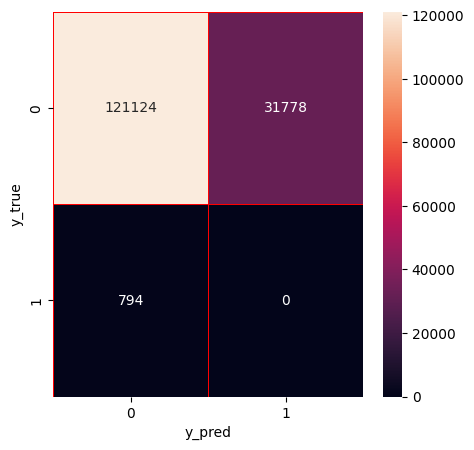

In [23]:
# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_pred_ksql_dos, average='binary')

# Print results
print('Accuracy of KSQL: ' + str(accuracy_score(y_true_dos, y_pred_ksql_dos)))
print('Precision of KSQL: ' + str(precision))
print('Recall of KSQL: ' + str(recall))
print('F1-score of KSQL: ' + str(fscore))
print(classification_report(y_true_dos, y_pred_ksql_dos, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_pred_ksql_dos)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Machine Learning

Prediction time per sample:  7.658290932532426e-05
Accuracy of DT: 0.9981521965438268
Precision of DT: 0.9961089494163424
Recall of DT: 0.6448362720403022
F1-score of DT: 0.7828746177370031
              precision    recall  f1-score   support

           0    0.99816   0.99999   0.99907    152902
           1    0.99611   0.64484   0.78287       794

    accuracy                        0.99815    153696
   macro avg    0.99713   0.82241   0.89097    153696
weighted avg    0.99815   0.99815   0.99796    153696



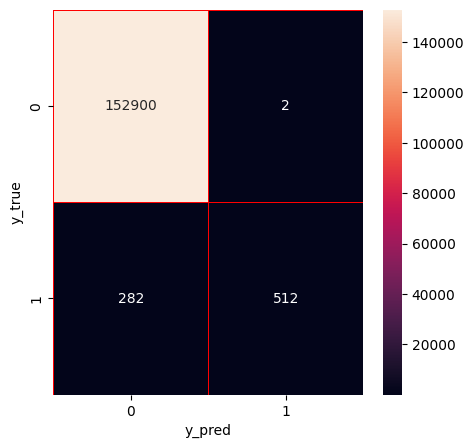

In [24]:
# Decision Tree
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = dt.predict(X_test_fs)
end = time.time()

predict_time_dt = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_dt)

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_predict, average='binary')

# Print results
print('Accuracy of DT: ' + str(accuracy_score(y_true_dos, y_predict)))
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true_dos, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.0012730394282391636
Accuracy of RF: 0.9981521965438268
Precision of RF: 0.9961089494163424
Recall of RF: 0.6448362720403022
F1-score of RF: 0.7828746177370031
              precision    recall  f1-score   support

           0    0.99816   0.99999   0.99907    152902
           1    0.99611   0.64484   0.78287       794

    accuracy                        0.99815    153696
   macro avg    0.99713   0.82241   0.89097    153696
weighted avg    0.99815   0.99815   0.99796    153696



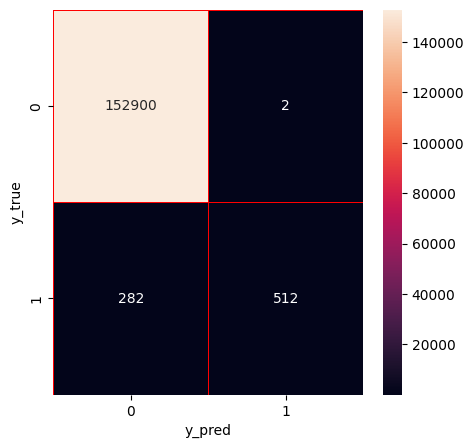

In [25]:
# Random Forest
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = rf.predict(X_test_fs)
end = time.time()

predict_time_rf = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_rf)

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_predict, average='binary')

# Print results
print('Accuracy of RF: ' + str(accuracy_score(y_true_dos, y_predict)))
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true_dos, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.0020111339950521813
Accuracy of ET: 0.9981587028940245
Precision of ET: 0.9980506822612085
Recall of ET: 0.6448362720403022
F1-score of ET: 0.7834736036725325
              precision    recall  f1-score   support

           0    0.99816   0.99999   0.99908    152902
           1    0.99805   0.64484   0.78347       794

    accuracy                        0.99816    153696
   macro avg    0.99810   0.82241   0.89127    153696
weighted avg    0.99816   0.99816   0.99796    153696



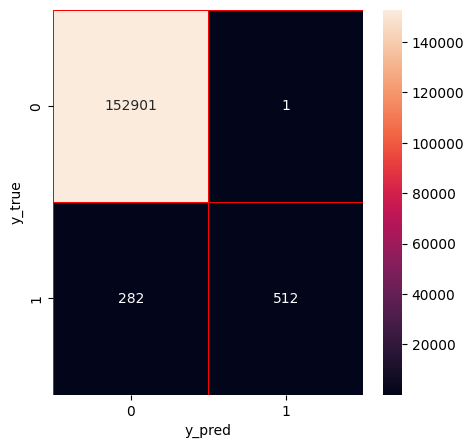

In [26]:
# Extra Trees
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = et.predict(X_test_fs)
end = time.time()

predict_time_et = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_et)

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_predict, average='binary')

# Print results
print('Accuracy of ET: ' + str(accuracy_score(y_true_dos, y_predict)))
print('Precision of ET: ' + str(precision))
print('Recall of ET: ' + str(recall))
print('F1-score of ET: ' + str(fscore))
print(classification_report(y_true_dos, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.000583098291134601
Accuracy of XG: 0.9976967520299813
Precision of XG: 1.0
Recall of XG: 0.5541561712846348
F1-score of XG: 0.713128038897893
              precision    recall  f1-score   support

           0    0.99769   1.00000   0.99884    152902
           1    1.00000   0.55416   0.71313       794

    accuracy                        0.99770    153696
   macro avg    0.99885   0.77708   0.85599    153696
weighted avg    0.99770   0.99770   0.99737    153696



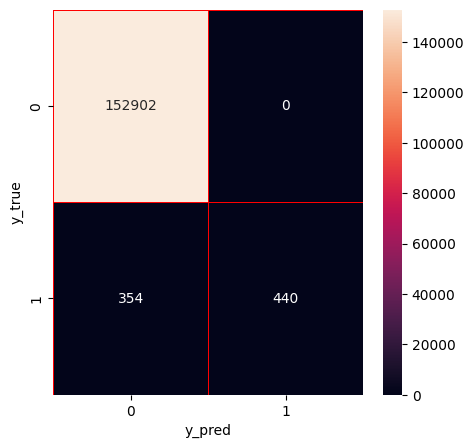

In [27]:
# XGBoost
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = xg.predict(X_test_fs)
end = time.time()

predict_time_xg = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_xg)

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_predict, average='binary')

# Print results
print('Accuracy of XG: ' + str(accuracy_score(y_true_dos, y_predict)))
print('Precision of XG: ' + str(precision))
print('Recall of XG: ' + str(recall))
print('F1-score of XG: ' + str(fscore))
print(classification_report(y_true_dos, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.0012630541300292118
Accuracy of LGBM: 0.9981521965438268
Precision of LGBM: 0.9961089494163424
Recall of LGBM: 0.6448362720403022
F1-score of LGBM: 0.7828746177370031
              precision    recall  f1-score   support

           0    0.99816   0.99999   0.99907    152902
           1    0.99611   0.64484   0.78287       794

    accuracy                        0.99815    153696
   macro avg    0.99713   0.82241   0.89097    153696
weighted avg    0.99815   0.99815   0.99796    153696



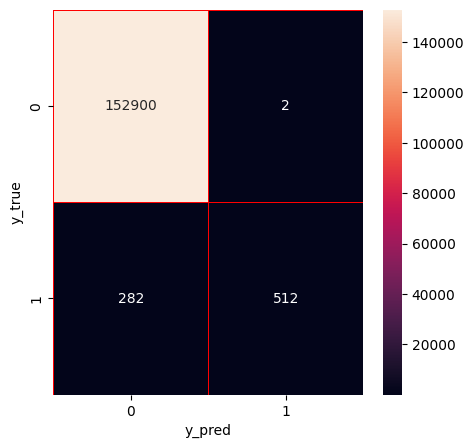

In [28]:
# LightGBM
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = lgbm.predict(X_test_fs)
end = time.time()

predict_time_lgbm = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_lgbm)

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_predict, average='binary')

# Print results
print('Accuracy of LGBM: ' + str(accuracy_score(y_true_dos, y_predict)))
print('Precision of LGBM: ' + str(precision))
print('Recall of LGBM: ' + str(recall))
print('F1-score of LGBM: ' + str(fscore))
print(classification_report(y_true_dos, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.00035935904665487697
Accuracy of Cat: 0.9977097647303769
Precision of Cat: 1.0
Recall of Cat: 0.5566750629722922
F1-score of Cat: 0.7152103559870551
              precision    recall  f1-score   support

           0    0.99770   1.00000   0.99885    152902
           1    1.00000   0.55668   0.71521       794

    accuracy                        0.99771    153696
   macro avg    0.99885   0.77834   0.85703    153696
weighted avg    0.99772   0.99771   0.99738    153696



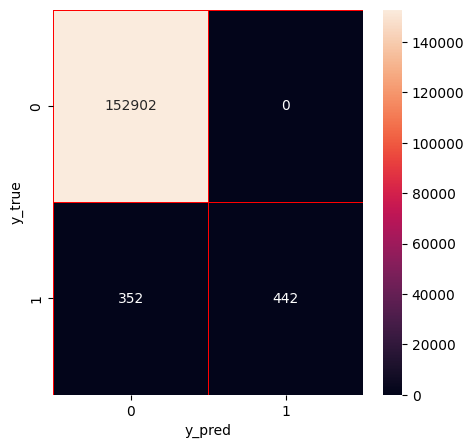

In [29]:
# CatBoost
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = cat.predict(X_test_fs)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test_fs)*1000)

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_predict, average='binary')

# Print results
print('Accuracy of Cat: ' + str(accuracy_score(y_true_dos, y_predict)))
print('Precision of Cat: ' + str(precision))
print('Recall of Cat: ' + str(recall))
print('F1-score of Cat: ' + str(fscore))
print(classification_report(y_true_dos, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [30]:
top_3_models

['rf', 'xg', 'et']

Prediction time per sample:  0.007661782761998109
Accuracy of OCSE: 0.9976967520299813
Precision of OCSE: 1.0
Recall of OCSE: 0.5541561712846348
F1-score of OCSE: 0.713128038897893
              precision    recall  f1-score   support

           0    0.99769   1.00000   0.99884    152902
           1    1.00000   0.55416   0.71313       794

    accuracy                        0.99770    153696
   macro avg    0.99885   0.77708   0.85599    153696
weighted avg    0.99770   0.99770   0.99737    153696



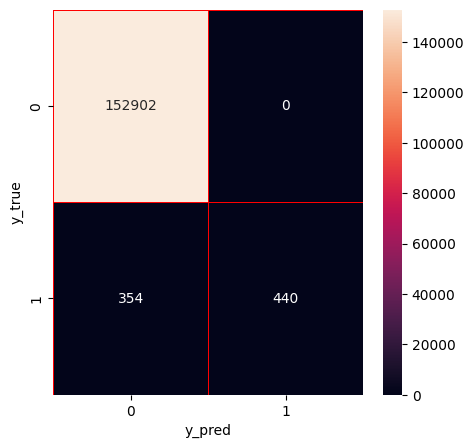

In [31]:
# OCSE

# !!! WARNING: always update based used models below based on top_3_models in training !!!
start = time.time()

model_1_test = rf.predict(X_test_fs).reshape(-1, 1)
model_2_test = xg.predict(X_test_fs).reshape(-1, 1)
model_3_test = et.predict(X_test_fs).reshape(-1, 1)

model_1_prob_test = rf.predict_proba(X_test_fs)
model_2_prob_test = xg.predict_proba(X_test_fs)
model_3_prob_test = et.predict_proba(X_test_fs)

x_test = np.concatenate([model_1_test, model_2_test, model_3_test] + [model_1_prob_test, model_2_prob_test, model_3_prob_test], axis=1)

y_predict = ocse.predict(x_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test_fs)*1000)

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_predict, average='binary')

# Print results
print('Accuracy of OCSE: ' + str(accuracy_score(y_true_dos, y_predict)))
print('Precision of OCSE: ' + str(precision))
print('Recall of OCSE: ' + str(recall))
print('F1-score of OCSE: ' + str(fscore))
print(classification_report(y_true_dos, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

### Port Scan

In [32]:
dt = joblib.load(f"{PS_MODEL_LOCATION}/dt_tuned.pkl")
rf = joblib.load(f"{PS_MODEL_LOCATION}/rf_tuned_single.pkl")
et = joblib.load(f"{PS_MODEL_LOCATION}/et_tuned_single.pkl")
xg = joblib.load(f"{PS_MODEL_LOCATION}/xg_tuned_single.pkl")
lgbm = joblib.load(f"{PS_MODEL_LOCATION}/lgbm_tuned_single.pkl")
cat = joblib.load(f"{PS_MODEL_LOCATION}/cat_tuned_single.pkl")
stk3 = joblib.load(f"{PS_MODEL_LOCATION}/ocse_tuned_single.pkl")

fs = ['Bwd RST Flags', 'Flow Duration', 'RST Flag Count', 'Fwd Segment Size Avg', 'Packet Length Mean', 'Protocol', 'Fwd Seg Size Min', 'Average Packet Size', 'Total Length of Fwd Packet', 'Flow IAT Max', 'Flow Bytes/s', 'Bwd Packets/s', 'Fwd Packet Length Max', 'Down/Up Ratio', 'Packet Length Max', 'Fwd Header Length', 'Bwd Segment Size Avg', 'Bwd Packet Length Max', 'FWD Init Win Bytes', 'Fwd Packet Length Mean', 'Bwd Packet Length Mean', 'Fwd Act Data Pkts', 'Bwd Packet Length Std', 'Total Length of Bwd Packet', 'Bwd Act Data Pkts', 'Packet Length Std', 'Bwd Init Win Bytes']

top_3_models = ['et', 'lgbm', 'rf']

labelencoder = LabelEncoder()
labelencoder.fit_transform(['Not Portscan', 'Portscan'])

X_test_fs = flink_test[fs]
y_test = labelencoder.transform(flink_test_binary_ps['Binary Label'])

#### KSQL

In [33]:
y_pred_ksql_ps = labelencoder.transform(y_pred_ksql_ps)
y_true_ps = labelencoder.transform(y_true_ps)

Accuracy of KSQL: 0.9881389235894232
Precision of KSQL: 0.9458736059479554
Recall of KSQL: 0.9999056841046278
F1-score of KSQL: 0.9721394403435575
              precision    recall  f1-score   support

           0    0.99998   0.98507   0.99247    121888
           1    0.94587   0.99991   0.97214     31808

    accuracy                        0.98814    153696
   macro avg    0.97292   0.99249   0.98230    153696
weighted avg    0.98878   0.98814   0.98826    153696



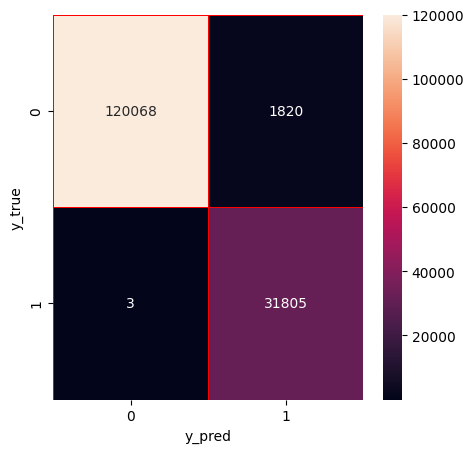

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix,precision_recall_fscore_support, accuracy_score

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_ps, y_pred_ksql_ps, average='binary')

# Print results
print('Accuracy of KSQL: ' + str(accuracy_score(y_true_ps, y_pred_ksql_ps)))
print('Precision of KSQL: ' + str(precision))
print('Recall of KSQL: ' + str(recall))
print('F1-score of KSQL: ' + str(fscore))
print(classification_report(y_true_ps, y_pred_ksql_ps, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_ps, y_pred_ksql_ps)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Machine Learning

Prediction time per sample:  6.138856476007985e-05
Accuracy of DT: 0.9995185300853633
Precision of DT: 1.0
Recall of DT: 0.9976735412474849
F1-score of DT: 0.998835415945359
              precision    recall  f1-score   support

           0    0.99939   1.00000   0.99970    121888
           1    1.00000   0.99767   0.99884     31808

    accuracy                        0.99952    153696
   macro avg    0.99970   0.99884   0.99927    153696
weighted avg    0.99952   0.99952   0.99952    153696



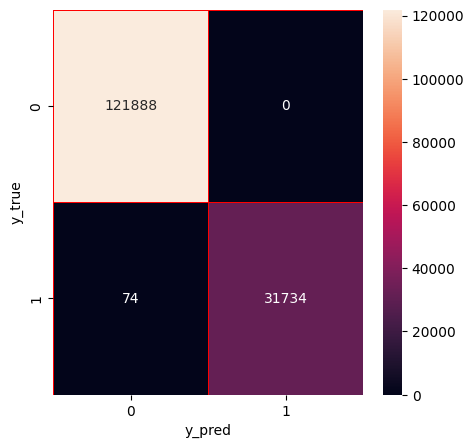

In [35]:
# Decision Tree
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = dt.predict(X_test_fs)
end = time.time()

predict_time_dt = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_dt)

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_ps, y_predict, average='binary')

# Print results
print('Accuracy of DT: ' + str(accuracy_score(y_true_ps, y_predict)))
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true_ps, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_ps, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.0009428560051251868
Accuracy of RF: 0.9995966062877368
Precision of RF: 1.0
Recall of RF: 0.9980508048289738
F1-score of RF: 0.9990244516474179
              precision    recall  f1-score   support

           0    0.99949   1.00000   0.99975    121888
           1    1.00000   0.99805   0.99902     31808

    accuracy                        0.99960    153696
   macro avg    0.99975   0.99903   0.99939    153696
weighted avg    0.99960   0.99960   0.99960    153696



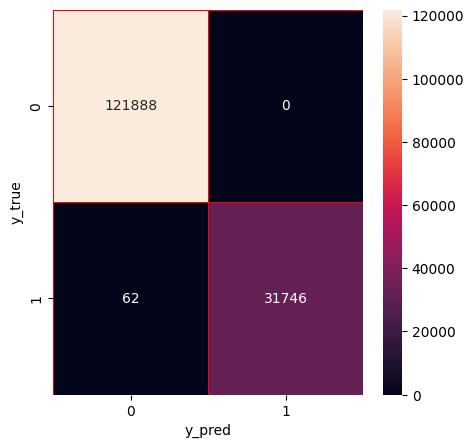

In [36]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report, confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

# Random Forest
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = rf.predict(X_test_fs)
end = time.time()

predict_time_rf = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_rf)

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_ps, y_predict, average='binary')

# Print results
print('Accuracy of RF: ' + str(accuracy_score(y_true_ps, y_predict)))
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true_ps, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_ps, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.001637317440347475
Accuracy of ET: 0.9991021236727046
Precision of ET: 1.0
Recall of ET: 0.9956614688128773
F1-score of ET: 0.9978260184630896
              precision    recall  f1-score   support

           0    0.99887   1.00000   0.99943    121888
           1    1.00000   0.99566   0.99783     31808

    accuracy                        0.99910    153696
   macro avg    0.99943   0.99783   0.99863    153696
weighted avg    0.99910   0.99910   0.99910    153696



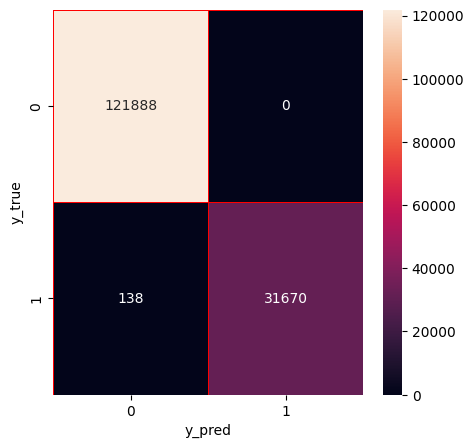

In [37]:
# Extra Trees
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = et.predict(X_test_fs)
end = time.time()

predict_time_et = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_et)

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_ps, y_predict, average='binary')

# Print results
print('Accuracy of ET: ' + str(accuracy_score(y_true_ps, y_predict)))
print('Precision of ET: ' + str(precision))
print('Recall of ET: ' + str(recall))
print('F1-score of ET: ' + str(fscore))
print(classification_report(y_true_ps, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_ps, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.0004686668046732483
Accuracy of XG: 0.9995966062877368
Precision of XG: 1.0
Recall of XG: 0.9980508048289738
F1-score of XG: 0.9990244516474179
              precision    recall  f1-score   support

           0    0.99949   1.00000   0.99975    121888
           1    1.00000   0.99805   0.99902     31808

    accuracy                        0.99960    153696
   macro avg    0.99975   0.99903   0.99939    153696
weighted avg    0.99960   0.99960   0.99960    153696



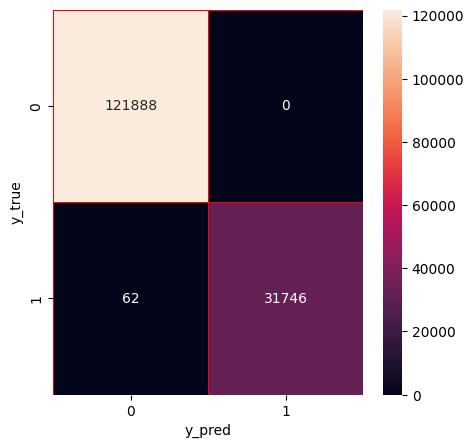

In [38]:
# XGBoost
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = xg.predict(X_test_fs)
end = time.time()

predict_time_xg = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_xg)

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_ps, y_predict, average='binary')

# Print results
print('Accuracy of XG: ' + str(accuracy_score(y_true_ps, y_predict)))
print('Precision of XG: ' + str(precision))
print('Recall of XG: ' + str(recall))
print('F1-score of XG: ' + str(fscore))
print(classification_report(y_true_ps, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_ps, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.0008871294472730336
Accuracy of LGBM: 0.9996031126379347
Precision of LGBM: 0.9999370098579572
Recall of LGBM: 0.998145120724346
F1-score of LGBM: 0.9990402618039932
              precision    recall  f1-score   support

           0    0.99952   0.99998   0.99975    121888
           1    0.99994   0.99815   0.99904     31808

    accuracy                        0.99960    153696
   macro avg    0.99973   0.99906   0.99940    153696
weighted avg    0.99960   0.99960   0.99960    153696



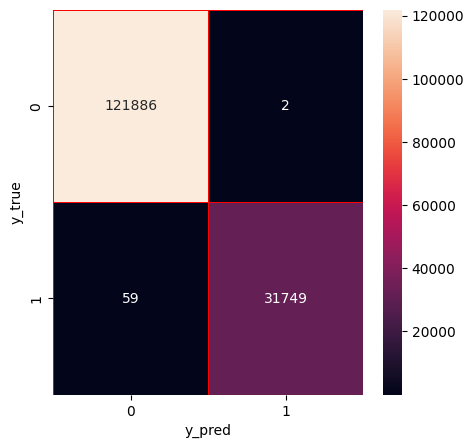

In [39]:
# LightGBM
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = lgbm.predict(X_test_fs)
end = time.time()

predict_time_lgbm = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_lgbm)

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_ps, y_predict, average='binary')

# Print results
print('Accuracy of LGBM: ' + str(accuracy_score(y_true_ps, y_predict)))
print('Precision of LGBM: ' + str(precision))
print('Recall of LGBM: ' + str(recall))
print('F1-score of LGBM: ' + str(fscore))
print(classification_report(y_true_ps, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_ps, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.00038737124411880586
Accuracy of Cat: 0.9995966062877368
Precision of Cat: 1.0
Recall of Cat: 0.9980508048289738
F1-score of Cat: 0.9990244516474179
              precision    recall  f1-score   support

           0    0.99949   1.00000   0.99975    121888
           1    1.00000   0.99805   0.99902     31808

    accuracy                        0.99960    153696
   macro avg    0.99975   0.99903   0.99939    153696
weighted avg    0.99960   0.99960   0.99960    153696



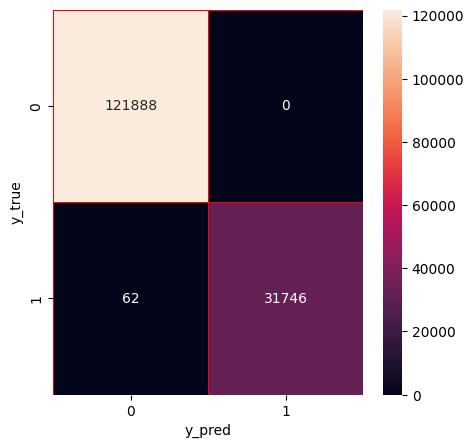

In [40]:
# CatBoost
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = cat.predict(X_test_fs)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test_fs)*1000)

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_ps, y_predict, average='binary')

# Print results
print('Accuracy of Cat: ' + str(accuracy_score(y_true_ps, y_predict)))
print('Precision of Cat: ' + str(precision))
print('Recall of Cat: ' + str(recall))
print('F1-score of Cat: ' + str(fscore))
print(classification_report(y_true_ps, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_ps, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [41]:
top_3_models

['et', 'lgbm', 'rf']

Prediction time per sample:  0.007876085845376213
Accuracy of OCSE: 0.9996031126379347
Precision of OCSE: 0.9999370098579572
Recall of OCSE: 0.998145120724346
F1-score of OCSE: 0.9990402618039932
              precision    recall  f1-score   support

           0    0.99952   0.99998   0.99975    121888
           1    0.99994   0.99815   0.99904     31808

    accuracy                        0.99960    153696
   macro avg    0.99973   0.99906   0.99940    153696
weighted avg    0.99960   0.99960   0.99960    153696



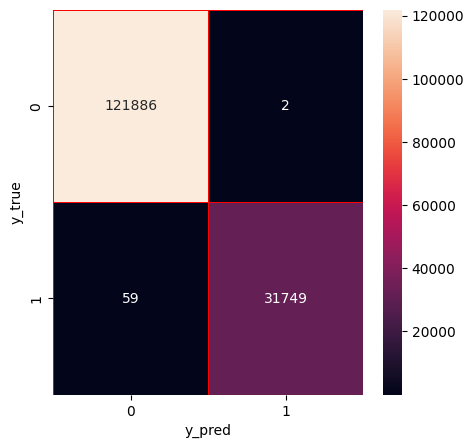

In [42]:
# OCSE

# !!! WARNING: always update based used models below based on top_3_models in training !!!
start = time.time()

model_1_test = et.predict(X_test_fs).reshape(-1, 1)
model_2_test = lgbm.predict(X_test_fs).reshape(-1, 1)
model_3_test = rf.predict(X_test_fs).reshape(-1, 1)

model_1_prob_test = et.predict_proba(X_test_fs)
model_2_prob_test = lgbm.predict_proba(X_test_fs)
model_3_prob_test = rf.predict_proba(X_test_fs)

x_test = np.concatenate([model_1_test, model_2_test, model_3_test] + [model_1_prob_test, model_2_prob_test, model_3_prob_test], axis=1)

y_predict = stk3.predict(x_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test_fs)*1000)

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_ps, y_predict, average='binary')

# Print results
print('Accuracy of OCSE: ' + str(accuracy_score(y_true_ps, y_predict)))
print('Precision of OCSE: ' + str(precision))
print('Recall of OCSE: ' + str(recall))
print('F1-score of OCSE: ' + str(fscore))
print(classification_report(y_true_ps, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_ps, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Inference Time

In [45]:
TRIES = 100

In [52]:
# this is in milliseconds, not seconds
def calculate_inference_time_in_ms(foo, tries: int):
    times = []
    for _ in range(tries):
        start = time.time()
        foo()
        end = time.time()
        times.append(((end - start) / len(X_test_fs)) * 1000)
    print(times)
    return np.average(times)

In [47]:
def print_time(name: str, in_ms):
    print(f"Average Inference time for {name}")
    print(in_ms, 'milliseconds')
    print(in_ms / 1000, 'seconds')
    print()

## DoS

In [43]:
dt = joblib.load(f"{DOS_MODEL_LOCATION}/dt_tuned.pkl")
rf = joblib.load(f"{DOS_MODEL_LOCATION}/rf_tuned_single.pkl")
et = joblib.load(f"{DOS_MODEL_LOCATION}/et_tuned_single.pkl")
xg = joblib.load(f"{DOS_MODEL_LOCATION}/xg_tuned_single.pkl")
lgbm = joblib.load(f"{DOS_MODEL_LOCATION}/lgbm_tuned_single.pkl")
cat = joblib.load(f"{DOS_MODEL_LOCATION}/cat_tuned_single.pkl")
ocse = joblib.load(f"{DOS_MODEL_LOCATION}/ocse_tuned_single.pkl")

fs = ['Bwd IAT Mean', 'Bwd IAT Max', 'Flow Duration', 'Fwd IAT Max', 'Idle Max', 'Flow IAT Max', 'Fwd Seg Size Min', 'Fwd IAT Total', 'Flow IAT Std', 'Idle Mean', 'Flow IAT Mean', 'Bwd IAT Total', 'Bwd IAT Min', 'Protocol', 'Fwd Bulk Rate Avg', 'Bwd Packet Length Max', 'Fwd Packets/s', 'Fwd IAT Mean', 'Flow Packets/s', 'Fwd PSH Flags', 'FWD Init Win Bytes', 'Total Length of Bwd Packet', 'Bwd Packet Length Mean', 'Bwd RST Flags', 'Fwd Packet Length Min', 'PSH Flag Count', 'SYN Flag Count', 'Bwd Segment Size Avg', 'RST Flag Count', 'Bwd Act Data Pkts', 'FIN Flag Count', 'Packet Length Std']

top_3_models = ['rf', 'xg', 'et']

labelencoder = LabelEncoder()
labelencoder.fit_transform(['Not Slowloris', 'Slowloris'])

X_test_fs = flink_test[fs]
y_test = labelencoder.transform(flink_test_binary_dos['Binary Label'])

In [48]:
dos_inference_times: list[tuple] = []

# Decision Tree
dos_inference_times.append(("DT", calculate_inference_time_in_ms(lambda: dt.predict(X_test_fs), TRIES)))
print(dos_inference_times[0])

# Random Forest
dos_inference_times.append(("RF", calculate_inference_time_in_ms(lambda: rf.predict(X_test_fs), TRIES)))
print(dos_inference_times[1])

# Extra Trees
dos_inference_times.append(("ET", calculate_inference_time_in_ms(lambda: et.predict(X_test_fs), TRIES)))
print(dos_inference_times[2])

# XGBoost
dos_inference_times.append(("XG", calculate_inference_time_in_ms(lambda: xg.predict(X_test_fs), TRIES)))
print(dos_inference_times[3])

# LightGBM
dos_inference_times.append(("LGBM", calculate_inference_time_in_ms(lambda: lgbm.predict(X_test_fs), TRIES)))
print(dos_inference_times[4])

# CatBoost
dos_inference_times.append(("Cat", calculate_inference_time_in_ms(lambda: cat.predict(X_test_fs, thread_count=1), TRIES)))
print(dos_inference_times[5])

# OCSE (Change based on training's top 3 models results)
def ocse_timer():
    model_1_test = xg.predict(X_test_fs).reshape(-1, 1)
    model_2_test = et.predict(X_test_fs).reshape(-1, 1)
    model_3_test = lgbm.predict(X_test_fs).reshape(-1, 1)

    model_1_prob_test = xg.predict_proba(X_test_fs)
    model_2_prob_test = et.predict_proba(X_test_fs)
    model_3_prob_test = lgbm.predict_proba(X_test_fs)

    x_test = np.concatenate([model_1_test, model_2_test, model_3_test] + [model_1_prob_test, model_2_prob_test, model_3_prob_test], axis=1)

    stk3.predict(x_test)

dos_inference_times.append(("OCSE", calculate_inference_time_in_ms(ocse_timer, TRIES)))
print(dos_inference_times[6])

('DT', 7.071482087829672e-05)
('RF', 0.0011859250309416188)
('ET', 0.001886591948173256)
('XG', 0.00035609835116981887)
('LGBM', 0.0012970582199871054)
('Cat', 0.0005147883495191422)
('OCSE', 0.007512359018006126)


In [49]:
dos_times = sorted(dos_inference_times, key=lambda x: x[1])
dos_times

[('DT', 7.071482087829672e-05),
 ('XG', 0.00035609835116981887),
 ('Cat', 0.0005147883495191422),
 ('RF', 0.0011859250309416188),
 ('LGBM', 0.0012970582199871054),
 ('ET', 0.001886591948173256),
 ('OCSE', 0.007512359018006126)]

In [50]:
[[a, format(b, '.5f')] for a, b in dos_times]

[['DT', '0.00007'],
 ['XG', '0.00036'],
 ['Cat', '0.00051'],
 ['RF', '0.00119'],
 ['LGBM', '0.00130'],
 ['ET', '0.00189'],
 ['OCSE', '0.00751']]

## Port Scan

In [51]:
dt = joblib.load(f"{PS_MODEL_LOCATION}/dt_tuned.pkl")
rf = joblib.load(f"{PS_MODEL_LOCATION}/rf_tuned_single.pkl")
et = joblib.load(f"{PS_MODEL_LOCATION}/et_tuned_single.pkl")
xg = joblib.load(f"{PS_MODEL_LOCATION}/xg_tuned_single.pkl")
lgbm = joblib.load(f"{PS_MODEL_LOCATION}/lgbm_tuned_single.pkl")
cat = joblib.load(f"{PS_MODEL_LOCATION}/cat_tuned_single.pkl")
stk3 = joblib.load(f"{PS_MODEL_LOCATION}/ocse_tuned_single.pkl")

fs = ['Bwd RST Flags', 'Flow Duration', 'RST Flag Count', 'Fwd Segment Size Avg', 'Packet Length Mean', 'Protocol', 'Fwd Seg Size Min', 'Average Packet Size', 'Total Length of Fwd Packet', 'Flow IAT Max', 'Flow Bytes/s', 'Bwd Packets/s', 'Fwd Packet Length Max', 'Down/Up Ratio', 'Packet Length Max', 'Fwd Header Length', 'Bwd Segment Size Avg', 'Bwd Packet Length Max', 'FWD Init Win Bytes', 'Fwd Packet Length Mean', 'Bwd Packet Length Mean', 'Fwd Act Data Pkts', 'Bwd Packet Length Std', 'Total Length of Bwd Packet', 'Bwd Act Data Pkts', 'Packet Length Std', 'Bwd Init Win Bytes']

top_3_models = ['et', 'lgbm', 'rf']

labelencoder = LabelEncoder()
labelencoder.fit_transform(['Not Portscan', 'Portscan'])

X_test_fs = flink_test[fs]
y_test = labelencoder.transform(flink_test_binary_ps['Binary Label'])

In [53]:
ps_inference_times: list[tuple] = []

# Decision Tree
ps_inference_times.append(("DT", calculate_inference_time_in_ms(lambda: dt.predict(X_test_fs), TRIES)))
print(ps_inference_times[0])

# Random Forest
ps_inference_times.append(("RF", calculate_inference_time_in_ms(lambda: rf.predict(X_test_fs), TRIES)))
print(ps_inference_times[1])

# Extra Trees
ps_inference_times.append(("ET", calculate_inference_time_in_ms(lambda: et.predict(X_test_fs), TRIES)))
print(ps_inference_times[2])

# XGBoost
ps_inference_times.append(("XG", calculate_inference_time_in_ms(lambda: xg.predict(X_test_fs), TRIES)))
print(ps_inference_times[3])

# LightGBM
ps_inference_times.append(("LGBM", calculate_inference_time_in_ms(lambda: lgbm.predict(X_test_fs), TRIES)))
print(ps_inference_times[4])

# CatBoost
ps_inference_times.append(("Cat", calculate_inference_time_in_ms(lambda: cat.predict(X_test_fs, thread_count=1), TRIES)))
print(ps_inference_times[5])

# OCSE (Change based on training's top 3 models results)
def ocse_timer():
    model_1_test = et.predict(X_test_fs).reshape(-1, 1)
    model_2_test = lgbm.predict(X_test_fs).reshape(-1, 1)
    model_3_test = rf.predict(X_test_fs).reshape(-1, 1)

    model_1_prob_test = et.predict_proba(X_test_fs)
    model_2_prob_test = lgbm.predict_proba(X_test_fs)
    model_3_prob_test = rf.predict_proba(X_test_fs)

    x_test = np.concatenate([model_1_test, model_2_test, model_3_test] + [model_1_prob_test, model_2_prob_test, model_3_prob_test], axis=1)

    stk3.predict(x_test)

ps_inference_times.append(("OCSE", calculate_inference_time_in_ms(ocse_timer, TRIES)))
print(ps_inference_times[6])

[0.00011443458893089127, 9.502864196701098e-05, 7.297008354763624e-05, 6.625323699658894e-05, 5.717541112667468e-05, 5.577774859953989e-05, 6.647661480336743e-05, 7.856073365617538e-05, 5.508589789243432e-05, 5.467792314810974e-05, 7.022594924075341e-05, 6.171432406163182e-05, 5.758803957530714e-05, 5.565364981799629e-05, 7.011270910259488e-05, 6.103953693698849e-05, 5.712111790974935e-05, 5.2878490815727556e-05, 5.467326944380186e-05, 5.882747615597384e-05, 6.126291474376696e-05, 5.4251333586553616e-05, 5.388213971146141e-05, 5.755391241038265e-05, 5.742981362883905e-05, 5.460811758349147e-05, 5.4386291011482284e-05, 7.395201515659997e-05, 6.0903028277290526e-05, 5.406518541423822e-05, 5.393953539792533e-05, 5.3554829175140166e-05, 5.35144970711385e-05, 5.353000941883145e-05, 5.353466312313934e-05, 5.46593083308782e-05, 5.6460291898029685e-05, 5.643236967218237e-05, 6.290567236445037e-05, 5.8864705790436916e-05, 5.716300124852031e-05, 5.455847807087403e-05, 5.328801679482143e-05, 5.61

In [54]:
ps_times = sorted(ps_inference_times, key=lambda x: x[1])
ps_times

[('DT', 5.857059167817859e-05),
 ('XG', 0.0004220886383606646),
 ('LGBM', 0.0008407167511732907),
 ('RF', 0.0009044318888650546),
 ('Cat', 0.001245850300431475),
 ('ET', 0.0016645783127632436),
 ('OCSE', 0.006671846223180304)]

In [55]:
[[a, format(b, '.5f')] for a, b in ps_times]

[['DT', '0.00006'],
 ['XG', '0.00042'],
 ['LGBM', '0.00084'],
 ['RF', '0.00090'],
 ['Cat', '0.00125'],
 ['ET', '0.00166'],
 ['OCSE', '0.00667']]

In [56]:
[[a, format(b, '.5f')] for a, b in dos_times]

[['DT', '0.00007'],
 ['XG', '0.00036'],
 ['Cat', '0.00051'],
 ['RF', '0.00119'],
 ['LGBM', '0.00130'],
 ['ET', '0.00189'],
 ['OCSE', '0.00751']]

## Bad ksqlDB Port Scan Analysis

In [27]:
ksqldb_success = flink_test_binary_ps[(flink_test_binary_ps['Binary Prediction'] == 'Portscan') & (flink_test_binary_ps['Label'] == 'Portscan')]

In [19]:
ksqldb_failed = flink_test_binary_ps[(flink_test_binary_ps['Binary Prediction'] == 'Portscan') & (flink_test_binary_ps['Label'] == 'Benign')]

In [20]:
ksqldb_failed[(ksqldb_failed["Src IP"] == "192.168.10.3") | (ksqldb_failed["Dst IP"] == "192.168.10.3")]

,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,...,ICMP Type,Fwd TCP Retrans. Count,Bwd TCP Retrans. Count,Total TCP Retrans. Count,Total Connection Flow Time,Label,Old Index,Binary Prediction,_merge,Binary Label
66614,192.168.10.50,42506,192.168.10.3,389,6,2017-07-07 17:55:48.251761,579.0,12,7,172.0,...,0,6,3,9,579,Benign,888568,Portscan,both,Not Portscan
66615,192.168.10.50,58198,192.168.10.3,88,6,2017-07-07 17:55:48.270006,1276.0,10,9,3174.0,...,0,6,4,10,1276,Benign,743697,Portscan,both,Not Portscan
77113,192.168.10.50,19458,192.168.10.3,53,17,2017-07-07 17:55:48.251182,233.0,2,2,80.0,...,0,0,0,0,233,Benign,746040,Portscan,both,Not Portscan
77114,192.168.10.50,11299,192.168.10.3,53,17,2017-07-07 17:55:48.252390,229.0,2,2,138.0,...,0,0,0,0,229,Benign,943180,Portscan,both,Not Portscan
77115,192.168.10.50,54695,192.168.10.3,53,17,2017-07-07 17:55:48.252750,200.0,2,2,76.0,...,0,0,0,0,200,Benign,665346,Portscan,both,Not Portscan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151075,192.168.10.14,62615,192.168.10.3,53,17,2017-07-07 19:13:59.632983,204.0,2,2,76.0,...,0,0,0,0,204,Benign,1009948,Portscan,both,Not Portscan
151076,192.168.10.14,63259,192.168.10.3,53,17,2017-07-07 19:13:59.919958,338.0,2,2,60.0,...,0,0,0,0,338,Benign,642528,Portscan,both,Not Portscan
151077,192.168.10.14,53264,192.168.10.3,53,17,2017-07-07 19:13:59.920561,204.0,2,2,60.0,...,0,0,0,0,204,Benign,542723,Portscan,both,Not Portscan
151078,192.168.10.3,62473,192.168.10.1,53,17,2017-07-07 19:13:59.921258,60053.0,1,1,55.0,...,0,0,0,0,60053,Benign,462798,Portscan,both,Not Portscan


In [21]:
ksqldb_failed[(ksqldb_failed["Src IP"] == "192.168.10.3")]["Dst Port"].unique()

array([ 53, 137])

In [22]:
dns_dc_idx = ksqldb_failed[(ksqldb_failed["Src IP"] == "192.168.10.3") | (ksqldb_failed["Dst IP"] == "192.168.10.3")].index

In [37]:
failed_dc = set(ksqldb_failed.loc[dns_dc_idx]['Timestamp'].sort_values().dt.floor('s').unique())

In [38]:
success = set(ksqldb_success['Timestamp'].sort_values().dt.floor('s').unique())

In [39]:
failed_non_dc = set(ksqldb_failed[~ksqldb_failed.index.isin(dns_dc_idx)]['Timestamp'].sort_values().dt.floor('s').unique())

In [42]:
flow_start_time_diff = failed_non_dc.difference(success.union(failed_dc))
flow_start_time_diff

{Timestamp('2017-07-07 17:55:58')}

In [43]:
ksqldb_failed

,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,...,ICMP Type,Fwd TCP Retrans. Count,Bwd TCP Retrans. Count,Total TCP Retrans. Count,Total Connection Flow Time,Label,Old Index,Binary Prediction,_merge,Binary Label
66614,192.168.10.50,42506,192.168.10.3,389,6,2017-07-07 17:55:48.251761,579.0,12,7,172.0,...,0,6,3,9,579,Benign,888568,Portscan,both,Not Portscan
66615,192.168.10.50,58198,192.168.10.3,88,6,2017-07-07 17:55:48.270006,1276.0,10,9,3174.0,...,0,6,4,10,1276,Benign,743697,Portscan,both,Not Portscan
74612,192.168.10.8,8352,192.168.10.50,61904,6,2017-07-07 17:55:58.667877,23925.0,17,10,20514.0,...,0,4,5,9,23925,Benign,897704,Portscan,both,Not Portscan
74613,192.168.10.8,8351,192.168.10.50,21,6,2017-07-07 17:55:58.539781,152430.0,22,27,176.0,...,0,12,13,25,152430,Benign,989479,Portscan,both,Not Portscan
77015,192.168.10.50,6106,172.16.0.1,53126,6,2017-07-07 17:55:45.864352,1.0,1,1,0.0,...,0,0,0,0,1,Benign,669203,Portscan,both,Not Portscan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151075,192.168.10.14,62615,192.168.10.3,53,17,2017-07-07 19:13:59.632983,204.0,2,2,76.0,...,0,0,0,0,204,Benign,1009948,Portscan,both,Not Portscan
151076,192.168.10.14,63259,192.168.10.3,53,17,2017-07-07 19:13:59.919958,338.0,2,2,60.0,...,0,0,0,0,338,Benign,642528,Portscan,both,Not Portscan
151077,192.168.10.14,53264,192.168.10.3,53,17,2017-07-07 19:13:59.920561,204.0,2,2,60.0,...,0,0,0,0,204,Benign,542723,Portscan,both,Not Portscan
151078,192.168.10.3,62473,192.168.10.1,53,17,2017-07-07 19:13:59.921258,60053.0,1,1,55.0,...,0,0,0,0,60053,Benign,462798,Portscan,both,Not Portscan


In [56]:
ksqldb_failed[~ksqldb_failed.index.isin(dns_dc_idx)]['Timestamp']

74612     2017-07-07 17:55:58.667877
74613     2017-07-07 17:55:58.539781
77015     2017-07-07 17:55:45.864352
77016     2017-07-07 17:55:45.873339
77017     2017-07-07 17:55:45.880741
                     ...            
117680    2017-07-07 18:23:38.311104
117681    2017-07-07 18:23:38.333707
117682    2017-07-07 18:23:38.356204
117731    2017-07-07 18:23:51.959518
117732    2017-07-07 18:23:51.999930
Name: Timestamp, Length: 137, dtype: object

In [ ]:
dns_dc_idx = ksqldb_failed[(ksqldb_failed["Src IP"] == "192.168.10.3") | (ksqldb_failed["Dst IP"] == "192.168.10.3")].index

# Bad ML Slowloris Analysis

In [33]:
flink_train = pd.read_csv('../datasets/output/train_final_2.csv', index_col=0)
flink_test = pd.read_csv('../datasets/output/test_final_2.csv', index_col=0)

In [34]:
dt = joblib.load(f"{DOS_MODEL_LOCATION}/dt_tuned.pkl")
rf = joblib.load(f"{DOS_MODEL_LOCATION}/rf_tuned.pkl")
et = joblib.load(f"{DOS_MODEL_LOCATION}/et_tuned.pkl")
xg = joblib.load(f"{DOS_MODEL_LOCATION}/xg_tuned.pkl")
lgbm = joblib.load(f"{DOS_MODEL_LOCATION}/lgbm_tuned.pkl")
cat = joblib.load(f"{DOS_MODEL_LOCATION}/cat_tuned.pkl")
ocse = joblib.load(f"{DOS_MODEL_LOCATION}/ocse_tuned.pkl")

fs = ['Bwd IAT Mean', 'Bwd IAT Max', 'Flow Duration', 'Fwd IAT Max', 'Idle Max', 'Flow IAT Max', 'Fwd Seg Size Min', 'Fwd IAT Total', 'Flow IAT Std', 'Idle Mean', 'Flow IAT Mean', 'Bwd IAT Total', 'Bwd IAT Min', 'Protocol', 'Fwd Bulk Rate Avg', 'Bwd Packet Length Max', 'Fwd Packets/s', 'Fwd IAT Mean', 'Flow Packets/s', 'Fwd PSH Flags', 'FWD Init Win Bytes', 'Total Length of Bwd Packet', 'Bwd Packet Length Mean', 'Bwd RST Flags', 'Fwd Packet Length Min', 'PSH Flag Count', 'SYN Flag Count', 'Bwd Segment Size Avg', 'RST Flag Count', 'Bwd Act Data Pkts', 'FIN Flag Count', 'Packet Length Std']

top_3_models = ['rf', 'xg', 'et']

# OCSE (Change based on training's top 3 models results)
def ocse_pred(model, X):
    model_1_test = rf.predict(X).reshape(-1, 1)
    model_2_test = xg.predict(X).reshape(-1, 1)
    model_3_test = et.predict(X).reshape(-1, 1)

    model_1_prob_test = rf.predict_proba(X)
    model_2_prob_test = xg.predict_proba(X)
    model_3_prob_test = et.predict_proba(X)

    x_test = np.concatenate([model_1_test, model_2_test, model_3_test] + [model_1_prob_test, model_2_prob_test, model_3_prob_test], axis=1)

    return model.predict(x_test)

# labelencoder = LabelEncoder()
# labelencoder.fit_transform(['Not Slowloris', 'Slowloris'])

# X_test_fs = flink_test[fs]
# y_test = labelencoder.transform(flink_test_binary_dos['Binary Label'])

In [35]:
y_pred_rf = rf.predict(flink_test[fs])
y_pred_et = et.predict(flink_test[fs])
y_pred_xg = xg.predict(flink_test[fs])
y_pred_lgbm = lgbm.predict(flink_test[fs])
y_pred_cat = cat.predict(flink_test[fs])

In [36]:
flink_test = flink_test.reset_index()
flink_train = flink_train.reset_index()

In [37]:
slowloris_test = flink_test[flink_test['Label'] == 'Slowloris']

In [38]:
majority_not_slowloris = (y_pred_rf + y_pred_et + y_pred_xg + y_pred_lgbm + y_pred_cat) < 3
majority_fail_slowloris = slowloris_test[majority_not_slowloris[slowloris_test.index]]
majority_fail_slowloris

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Idle Max,Idle Min,ICMP Code,ICMP Type,Fwd TCP Retrans. Count,Bwd TCP Retrans. Count,Total TCP Retrans. Count,Total Connection Flow Time,Label,Old Index
2938,e1d75b7d-cba3-479b-af99-c3b5d3f7af43,172.16.0.1,54178,192.168.10.50,80,6,2017-07-05 13:08:15.865704,115877776.0,3,3,...,115873789.0,115873789.0,0,0,0,0,0,244909874,Slowloris,25714
2939,d5f63ee9-5c31-4ac6-b0cb-3b7f5541c6d0,172.16.0.1,54186,192.168.10.50,80,6,2017-07-05 13:08:15.865781,115877702.0,3,3,...,115873704.0,115873704.0,0,0,0,0,0,244909811,Slowloris,25719
2940,fd7a552a-4369-44fe-854b-44d75a388dd0,172.16.0.1,54190,192.168.10.50,80,6,2017-07-05 13:08:15.865809,115877676.0,3,3,...,115873707.0,115873707.0,0,0,0,0,0,244909758,Slowloris,25721
2941,a31d44de-faab-46e9-915c-6b5b540e8134,172.16.0.1,54198,192.168.10.50,80,6,2017-07-05 13:08:15.865865,115877620.0,3,3,...,115873534.0,115873534.0,0,0,0,0,0,244909631,Slowloris,25723
2942,6164b663-a38a-4505-84b5-3eb694f9c3e9,172.16.0.1,54188,192.168.10.50,80,6,2017-07-05 13:08:15.865777,115877708.0,3,3,...,115873719.0,115873719.0,0,0,0,0,0,244909792,Slowloris,25718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3376,d37edba9-0d3f-49e9-986f-8e0400fd26e9,172.16.0.1,33202,192.168.10.50,80,6,2017-07-05 13:09:39.323469,54359213.0,17,4,...,19948266.0,6416118.0,0,0,10,1,11,54359213,Slowloris,30661
3377,89df6280-a624-43bf-94cb-9a332436c1e3,172.16.0.1,33220,192.168.10.50,80,6,2017-07-05 13:09:43.343478,51363123.0,15,4,...,19948424.0,6423946.0,0,0,9,1,10,51363123,Slowloris,30688
3378,4ca5578e-c4b0-4d85-b981-e304b89de2e7,172.16.0.1,33210,192.168.10.50,80,6,2017-07-05 13:09:40.339200,54367420.0,17,4,...,19948403.0,6423943.0,0,0,11,1,12,54367420,Slowloris,30677
3380,aa606630-6b6e-4bc8-aa0b-d257cedc8417,172.16.0.1,33224,192.168.10.50,80,6,2017-07-05 13:09:45.206302,51292365.0,15,4,...,19692237.0,5070119.0,0,0,9,1,10,51292365,Slowloris,30691


In [39]:
majority_success_slowloris = slowloris_test[~slowloris_test.index.isin(majority_fail_slowloris.index)]
majority_success_slowloris

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Idle Max,Idle Min,ICMP Code,ICMP Type,Fwd TCP Retrans. Count,Bwd TCP Retrans. Count,Total TCP Retrans. Count,Total Connection Flow Time,Label,Old Index
324,2bea26cb-9d11-49aa-bc71-0feeae9c330d,172.16.0.1,60300,192.168.10.50,80,6,2017-07-05 13:05:56.233742,102601946.0,14,3,...,51263712.0,5776652.0,0,0,10,1,11,102601946,Slowloris,28611
338,4e9a605f-bf78-48e0-93e1-9ec398d2851a,172.16.0.1,60306,192.168.10.50,80,6,2017-07-05 13:05:58.020223,102607322.0,14,3,...,51263519.0,5780480.0,0,0,10,1,11,102607322,Slowloris,28614
339,4db75f68-d093-4ba9-bd51-cc91a7193526,172.16.0.1,60308,192.168.10.50,80,6,2017-07-05 13:05:58.021343,102606205.0,14,3,...,51263519.0,5780477.0,0,0,10,1,11,102606205,Slowloris,28615
342,f37135a3-c9f7-4b01-bb5f-41956243d746,172.16.0.1,60314,192.168.10.50,80,6,2017-07-05 13:05:59.092001,102687677.0,14,3,...,51327458.0,5744674.0,0,0,10,1,11,102687677,Slowloris,28617
343,48b937e7-c3e9-460c-be70-a48182ebb4a2,172.16.0.1,60316,192.168.10.50,80,6,2017-07-05 13:05:59.093010,102686671.0,14,3,...,51327460.0,5744639.0,0,0,10,1,11,102686671,Slowloris,28619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3657,f8deff34-63ba-4dfc-b6ac-a93a2282f9d1,172.16.0.1,33080,192.168.10.50,80,6,2017-07-05 13:09:15.302680,56437132.0,14,2,...,19756537.0,5129819.0,0,0,9,1,10,56437132,Slowloris,28855
3658,eed89a99-9391-4d43-8d4f-5f73a2f63ef7,172.16.0.1,33082,192.168.10.50,80,6,2017-07-05 13:09:15.302929,56434040.0,14,2,...,19756579.0,5126941.0,0,0,9,1,10,56434040,Slowloris,28856
3663,a254687d-c52b-49fe-bda0-f3a5e75912b2,172.16.0.1,33092,192.168.10.50,80,6,2017-07-05 13:09:17.015492,54719799.0,14,2,...,19944564.0,5718706.0,0,0,9,1,10,54719799,Slowloris,28857
3695,337c01e7-fad6-452e-9c35-d5c017bb69d1,172.16.0.1,33098,192.168.10.50,80,6,2017-07-05 13:09:18.182881,53553451.0,14,2,...,19820344.0,5842836.0,0,0,9,1,10,53553451,Slowloris,28858


In [40]:
slowloris_train = flink_train[flink_train['Label'] == 'Slowloris']

In [41]:
def show_kde_plot(selected_feature):
    _, axes = plt.subplots(1, 3, figsize=(18, 3))

    sns.kdeplot(data=slowloris_train[[selected_feature]], x=selected_feature, fill=True, ax=axes[0])
    axes[0].set_title(f'{selected_feature} on Training ({len(slowloris_train)} data)')
    axes[0].set_xlabel('Value')
    axes[0].set_ylabel('Density')

    sns.kdeplot(data=majority_success_slowloris[[selected_feature]], x=selected_feature, fill=True, ax=axes[1])
    axes[1].set_title(f'{selected_feature} on Success Test ({len(majority_success_slowloris)} data)')
    axes[1].set_xlabel('Value')
    axes[1].set_ylabel('Density')

    sns.kdeplot(data=majority_fail_slowloris[[selected_feature]], x=selected_feature, fill=True, ax=axes[2])
    axes[2].set_title(f'{selected_feature} on Failed Test ({len(majority_fail_slowloris)} data)')
    axes[2].set_xlabel('Value')
    axes[2].set_ylabel('Density')

    plt.show()

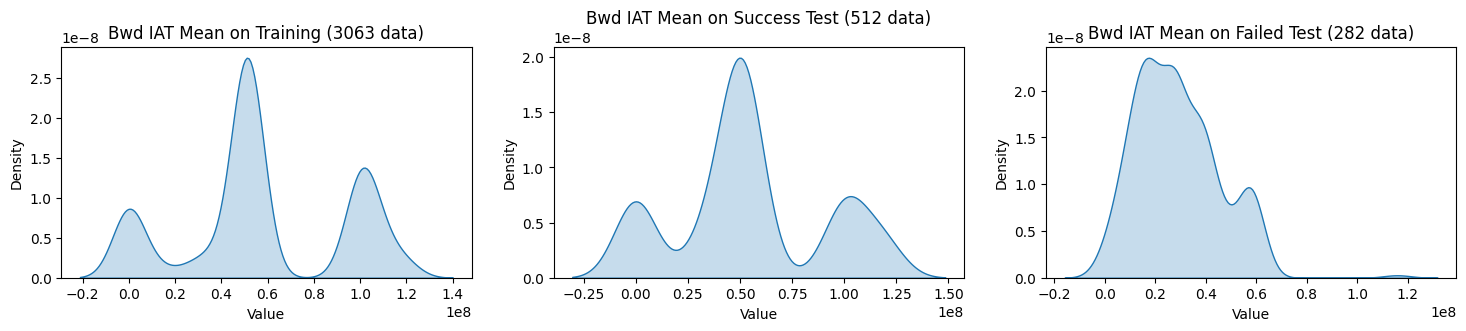

In [42]:
show_kde_plot('Bwd IAT Mean')

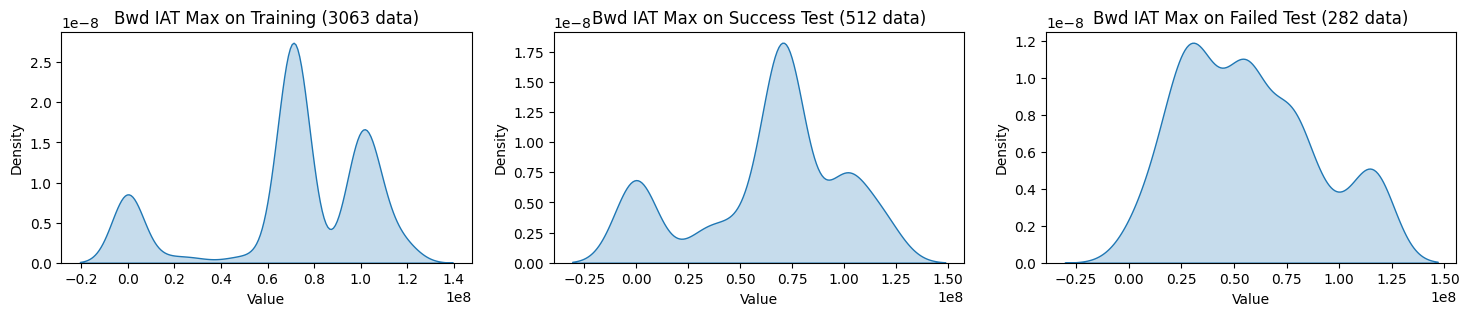

In [43]:
show_kde_plot('Bwd IAT Max')

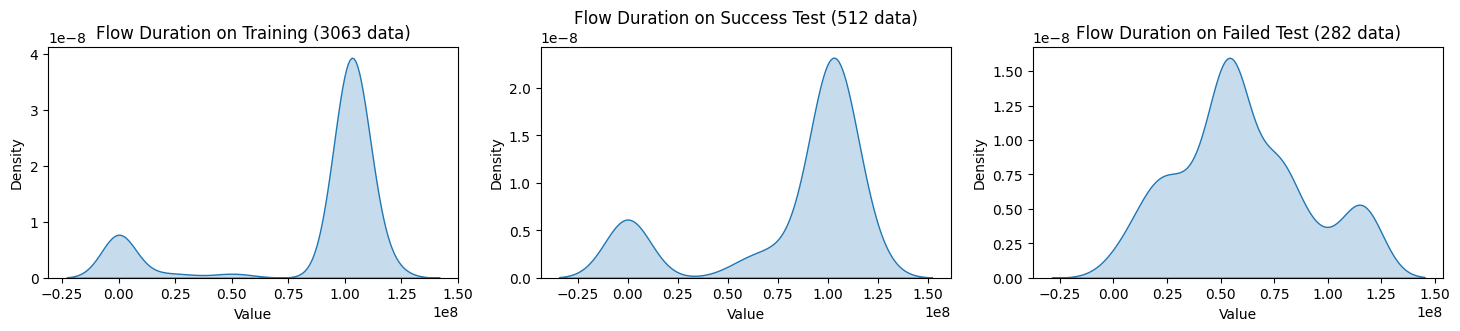

In [44]:
show_kde_plot('Flow Duration')